# LCPA 23-24 - "Hierarchical mergers of binary black holes"

<center><h1>Group 07</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |2103359         |
| Boccanera          | Eugenia               |                |
| Cacciola           | Martina               |2097476         |
| Lovato             | Matteo                |                |           

## 1. Introduction

A binary black hole (BBH) can form via close encounters of black holes (BHs) in a dense stellar environment, such as a nuclear star cluster (NSC), a globular cluster (GC) or a young star cluster (YSC). NSCs are very massive (~ $10^5 - 10^8 \, M_\odot$) star clusters lying at the center of some galaxies, including the Milky Way. GCs are old (~ 12 Gyr) massive (~ $10^4 - 10^6 M_\odot$) stellar clusters lying in the halo of galaxies. YSC are young (< 100 Myr) stellar clusters forming mostly in the disk of a galaxy.  

Several channels can lead to the formation of BBHs. But the distinctive signatures of the dynamical scenario is the formation of hierarchical mergers (IMs), i.e. repeated mergers of stellar-origin BHs that build up more massive one. This process is possible only in dense star clusters, where the merger remnant, which is initially a single BH, can pair up by dynamical exchanges or three-body encounter. The main obstacle to the formation of second-generation BHs via hierarchical mergers is the relativistic kick that the merger remnant receives at birth. This kick can be up to several thousand km/s. Hence, the interplay between the properties of the host star cluster (e.g., its escape velocity), those of the first-generation BBH population and the magnitude of the kick decides the maximum mass of a merger remnant in a given environment.  

A property that is being studied is that IM can build up IMBHs and also partially fill the pair instability (PI) mass gap between ~60 and ~120 $M_\odot$, explaining the formation of BBHs like GW190521.

#### Hierarchical mergers
When two stellar-born BHs merge via GW emission, their merger remnant is called second-generation (2g) BH. The 2g BH is a single object at birth. However, if it is retained inside its host star cluster, it may pair up dynamically with another BH. This gives birth to what we call a second-generation (2g) BBH, i.e. a binary black hole that hosts a 2g black hole . If a 2g binary black hole merges again, it gives birth to a third-generation (3g) BH, and so on. In this way, repeated black hole mergers in star clusters can give birth to hierarchical chains of mergers, leading to the formation of more and more massive black holes.

## 2. Goal of the project

Understand the differences between hierarchical binary black hole mergers in NSCs, GCc and YSc, by looking at a set of simulated BBHs. 
Our analysis will be carried out with classification ML algorithms, such as Random Forest and XGBoost. We will then proceed to analyze the importance of features in order to understand the properties of systems of BBHs.   

The idea is to split the analysis into two parts:

- Based on the features of the BBHs systems, figure out to which host star cluster these systems belong. 
  It's a classification problem with label the `label` column of the dataset corresponding to `0 -> GC, 1 -> NSC, 2 -> YSC`. Feature importance analysis will tell us which features are most important to understand which system belongs to which host stellar cluster.

- Analyze each stellar cluster independently. To do this we added a new label column `label_ngen`: `0` if the system has no other mergers beyond the 2nd generation; `1` if the system evolves beyond the 2nd generation.
  This is still a classification problem, this time with respect to `label_ngen`. Analysis of features importance will tell us which features are most important that lead systems to evolve and which do not.

To do this in a more detailed way, both globally (all labels together) and locally (single label), we will use `SHAP` values (Section ).

In order to have a cleaner notebook we created a file (`hmbh.py`) containing the functions needed to create the dataset, to train the ML models and to plot the results.

# 3. Dataset

The dynamical simulation were run for each host star cluster, with 12 different metallicities each. The files are found in the folders and subfolders: 

```python
folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']
```

Each `nth_generation.txt` dataset is composed of 28 columns. Among them we selected these: 

```python
cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27']
```

- c0: Identifier of the binary
- c1: Mass of the primary black hole in solar masses
- c2: Mass of the secondary black hole
  
- c3: Dimensionless spin magnitude of the primary black hole
- c4: Dimensionless spin magnitude of the secondary black hole
- c7: Initial semi-major axis of the binary black hole in solar radii
- c8: Initial orbital eccentricity of the binary black hole

- c9: Time requested for the dynamical pair up of the system in Myr
- c13: Time elapsed since the first-gen formation until the merger of the nth-gen system

- c15: Mass of the remnant
- c16: Dimensionless spin magnitude of the remnant black hole
- c17: Escape velocity from star cluster in km/s
- c25: Total mass of the stellar cluster
- c27: Number of generation of the system

We added two new columns, in the creation of the dataset:
- `label`: Identifies to which host star cluster a system belongs `0 -> GC, 1 -> NSC, 2 -> YSC`
- `label_ngen`: `0` if the system has no other mergers beyond the 2nd generation; `1` if the system evolves beyond the 2nd generation

### Import modules

In [8]:
import hmbh as h # custom module for data analysis

import numpy as np
import pandas as pd
import polars as pl

import matplotlib as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

## 3.1 Dataset creation

In order to create the dataset we use the custom function `create_dataset`. It used the `polars.DataFrame` object. 
Polars is fast DataFrame library for manipulating structured data. In order to be fast it optimizes queries to reduce unneeded work/memory allocations and adheres to a strict schema (data-types should be known before running the query). 
Polars leverages the concept of `LazyFrame`, Polars doesn't run each query line-by-line but instead processes the full query end-to-end. This lazy evaluation strategy allows for better memory management, making it possible to work with datasets that are too large to fit into RAM (it inherits the concept of "lazy" from Dask).

The speed-up is astonishing: an improvement of ~ 900% wrt using Pandas!

In the creation of the dataset we filter out those systems that take longer than Hubble time (~ 13.6 Gyr) to merge.
After creating the dataset, we rename the columns and we add the column `label_ngen`.

In [2]:
path = '../data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']


df = h.create_dataset(path, folder, metallicity, cols) # dataset creation

df = h.rename_columns(df, new_cols) # rename columns

df = h.get_label_ngen(df) # get label for n_gen

In [5]:
df.head(5)

ID,bh_mass1,bh_mass2,spin1,spin2,semimajor,i_ecc,time_dyn,time_merge,remnant_mass,remnant_spin,escape_vel,cluster_mass,n_gen,label,met,label_ngen
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i32
"""2.0.0""",28.497396,23.848129,0.734705,0.014536,118.322458,0.660875,73.920947,1746.620064,49.029268,0.816124,43.17523,456627.739325,2,0,0.0002,0
"""18.0.0""",38.172095,29.913274,0.753993,0.161852,378.031535,0.406799,38.064151,1712.47759,63.511846,0.840459,42.843056,375550.638468,2,0,0.0002,0
"""34.0.0""",60.53033,53.519905,0.720625,0.162188,608.965749,0.936663,240.687784,2461.291832,106.560909,0.825812,118.780296,5.4067e6,2,0,0.0002,0
"""38.0.0""",14.480868,13.043004,0.725751,0.111623,219.843013,0.361773,691.059977,7757.376544,25.747022,0.81898,76.422227,1.6841e6,2,0,0.0002,0
"""103.0.0""",19.224383,15.611048,0.742771,0.208234,28.765131,0.490608,2000.834621,7287.34974,32.475861,0.840732,103.880881,4.2546e6,2,0,0.0002,0


# 4. Visual description
Below we plot some important features and we provide a description of their distribution and relation with the host star cluster and the number of generations.

### 4.1 Masses

# 5. Classification analysis

In this section we describe the machine learning tasks and their results.

### 5.1 Data preprocessing

With `h.data_preprocessing` we prepare the dataset for the training and testing of the ML model.  
One important parameter is `balanced_label`. Having a balanced label dataset for a classifier. In our dataset very few systems, wrt other labels, belongs to `label` = 2 (YSC). This is a problem if we restrict the dataset to less samples than the total (i.e. using the `n_sample` parameter). In fact, on the restricted dataset the models struggle to generalize over the label 2. So if we decide to restrict our dataset is mandatory to balance the labels (and the maximum number of samples will be label_2 $\times$ 3).

Here below we show what we said above. We train a simple Random Forest (RF) model three times: 
- Full dataset w/o balanced labels
- Restricted dataset w/o balanced labels
- Restricted dataset w/ balanced labels

'+' 

model_evaluation w/o bar_plot to show difference in label performance.

##### 5.1.1 Full dataset w/o balanced labels

To run the simulation over the entire dataset it takes ~ 6 min 30 sec. We gain a pretty high accuracy on the test score, ~97%. But if we look at the confusion matrix, that tells us how the model had classified the samples, we see that ~50% of the label 2 are predicted as label 0. This is due to the fact that the label count of label 2 is 2 (3) order less than label 0 (1). The labels, in the complete dataset are unbalanced and lead to a bad generalization over unseen data.


Label count after sampling:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64

X_train shape: (2583317, 13)
X_test shape: (645830, 13)
y_train shape: (2583317,)
y_test shape: (645830,)

Training Score:        0.9979839872535968
Test score (Accuracy): 0.971031076289426



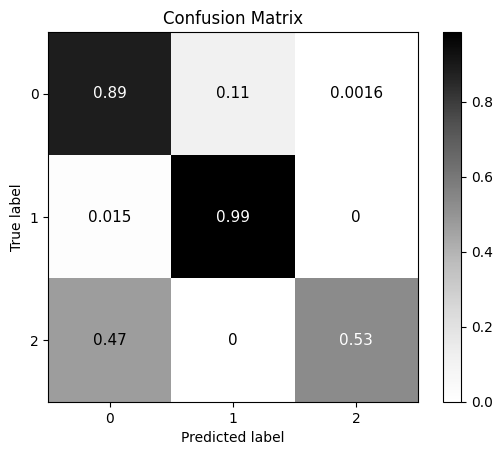

In [5]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False) # bar_plot=False because we don't want asses features importance

##### 5.1.2 Restricted dataset w/o balanced labels
This time we take 100.000 samples, among all the labels, that correspond to ~3% of the dataset. The label are unbalanced and in fact we can notice that label 2 is stille 2 (3) order less than the other two labels. The results are the same as before.  
This time we also do a test with `label_ngen` and we can see that label 0 is mis-labelled ~50% of the times.


Label count after sampling:
 label
1    86549
0    13240
2      211
Name: count, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.998
Test score (Accuracy): 0.9706



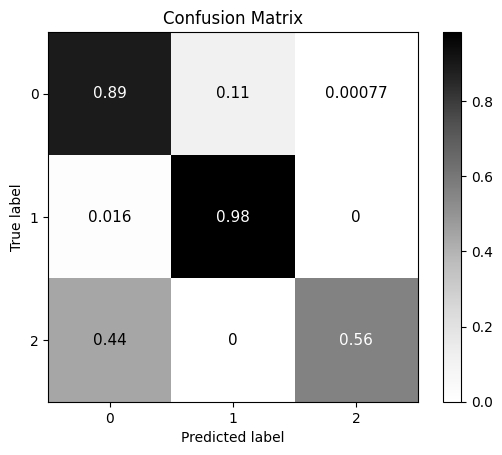

In [7]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False) # bar_plot=False because we don't want asses features importance


Label count after sampling:
 label_ngen
0    87483
1    12517
Name: count, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.9889625
Test score (Accuracy): 0.93795



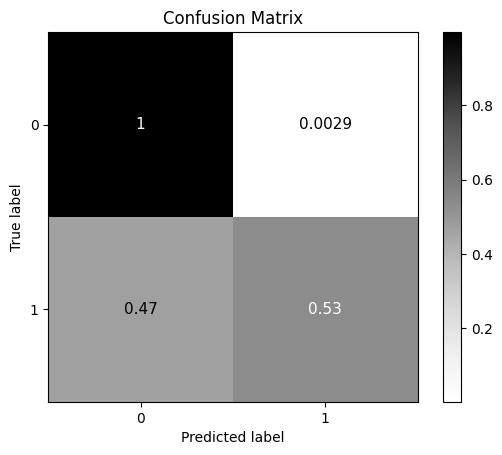

In [9]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=False)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)


##### 5.1.3 Restricted dataset w/ balanced labels

In this case either we downsample or not, the dataset will have $n_{sample} \le 7207\cdot3 = 21621$, that is ~0.66% of the complete dataset.  
This time, thanks to the balanced dataset, the labels are classified correctly with great accuracy ($\ge 88\,\%$). The test accuracy remains high, ~92%. 

Regarding the classification problem with `label_ngen`, the dataset will have $n_{sample} \le 401335\cdot2 = 802670$, that is ~24% of the complete dataset. We can downsample the dataset in order to gain some computational speed. 
The test accuracy is around ~79% and the correct predictions are ~87% and ~71%, for 0 and 1. This is an acceptable result but we have to keep in mind that we are working with a simple model.

Label count before balancing:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64 

Label count after balancing:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

Label count after sampling:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)

Training Score:        0.9943917668825162
Test score (Accuracy): 0.9197687861271676



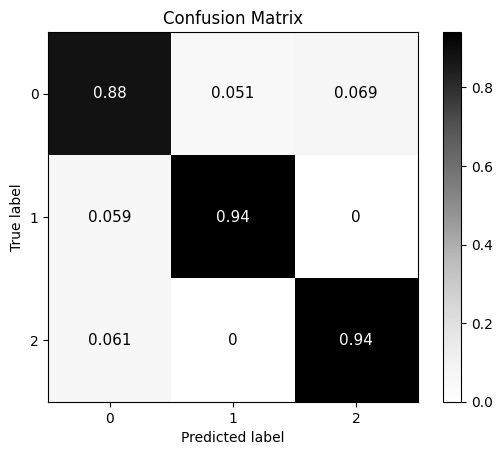

In [14]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)

Label count before balancing:
 label_ngen
0    2827812
1     401335
Name: count, dtype: int64 

Label count after balancing:
 label_ngen
0    401335
1    401335
Name: count, dtype: int64

Label count after sampling:
 label_ngen
0    50012
1    49988
Name: count, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)

Training Score:        0.9863875
Test score (Accuracy): 0.79195



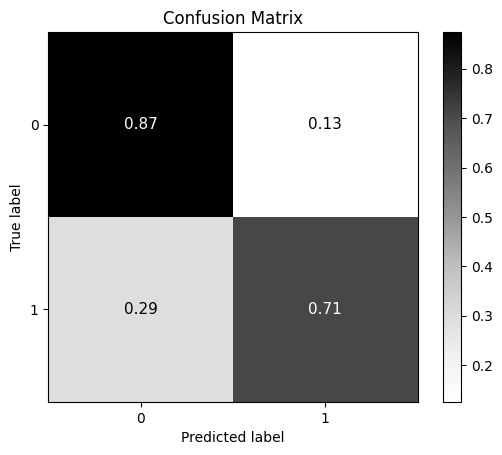

In [18]:
X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=True)

RF, y_pred = h.simple_RF(X_train, y_train, X_test)

h.model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred, bar_plot=False)

We do not propose a similar analysis with `XGBoost` for brevity. The results are the same as for the RF.  
So, given the results above, we can conclude that the best way is to work with a balanced dataset in order to have a better generalization over unseen data, thus improving model evaluation.

We've also seen that we can reduce the number of samples while retaining a good accuracy score. The next step is to understand what is the optimal size of the sample dataset.

## 5.2 Best dataset size

In this section we'll propose an analysis to understand which is the best sample size without loosing too much accuracy. This is done in order to gain computational speed.  
We'll use `plot_learning_curve` function. This function takes in input the data that we want to analyze and the ML model. It uses the `sklearn` `learning_curve` function to calculate the mean training/test scores. The `sklearn` function divides the input data in training set of different sizes.  
We can see that 14000 trining samples provides a good result for the mean test score. So we can guess that the finale model will have high accuracy if we use 18000 samples (that is a bit more that the sum of the training samples and the test samples, given the fact that we choose to use a test size of 20%).  
Similar tests are done with a simple XGB model and for `label_ngen`.

Label count before balancing:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64 

Label count after balancing:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

Label count after sampling:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)


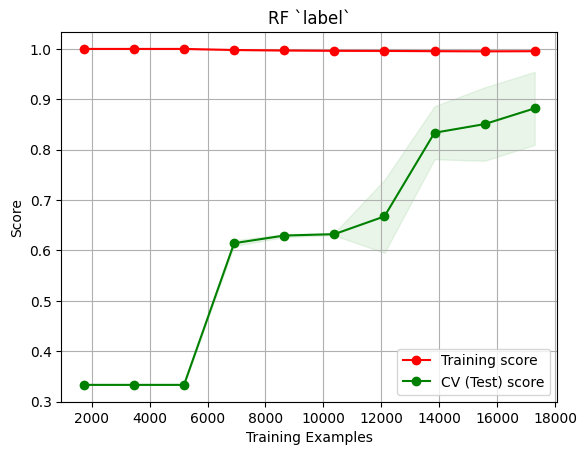

In [26]:
# `label` balanced dataset. Not downsampled

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=42) # simple RF model. The same used above

h.plot_learning_curve(RF, X, y, cv=5, title='RF `label`', train_sizes=np.linspace(0.1, 1.0, 10))

Label count before balancing:
 label
1    2788313
0     433627
2       7207
Name: count, dtype: int64 

Label count after balancing:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

Label count after sampling:
 label
1    7207
0    7207
2    7207
Name: count, dtype: int64

X_train shape: (17296, 13)
X_test shape: (4325, 13)
y_train shape: (17296,)
y_test shape: (4325,)


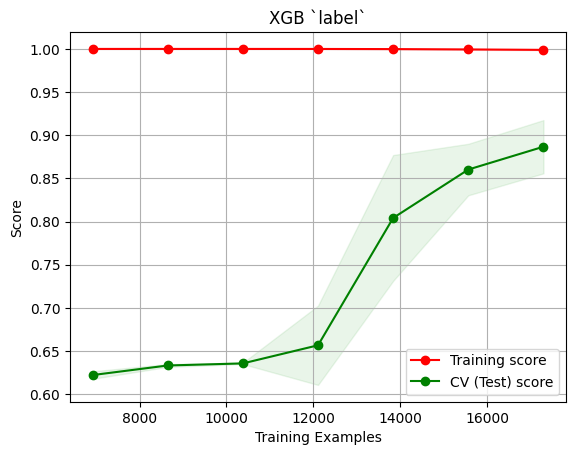

In [28]:
# `label` balanced dataset. Not downsampled

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=None, label='label', test_size=0.2, balanced_label=True)

XGB = XGBClassifier(random_state=42, tree_method='approx', n_jobs=4, **params,)

h.plot_learning_curve(XGB, X, y, cv=5, title='XGB `label`', train_sizes=np.linspace(0.1, 1.0, 10))

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    50012
1    49988
Name: label_ngen, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)


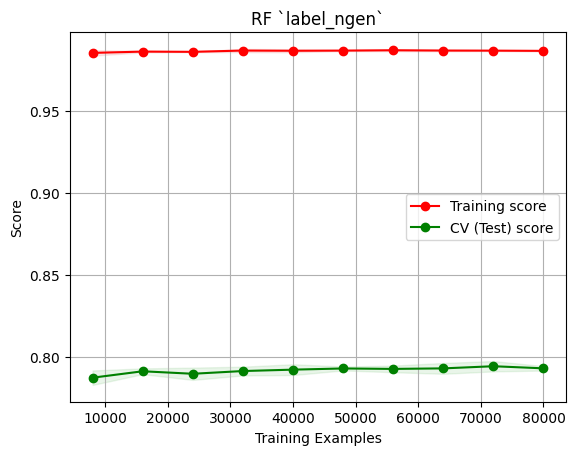

In [7]:
# `label_ngen` balanced dataset. 100_000 sample

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=True)

RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=42) # simple RF model. The same used above

h.plot_learning_curve(RF, X, y, cv=5, title='RF `label_ngen`', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=25)

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    50012
1    49988
Name: label_ngen, dtype: int64

X_train shape: (80000, 13)
X_test shape: (20000, 13)
y_train shape: (80000,)
y_test shape: (20000,)


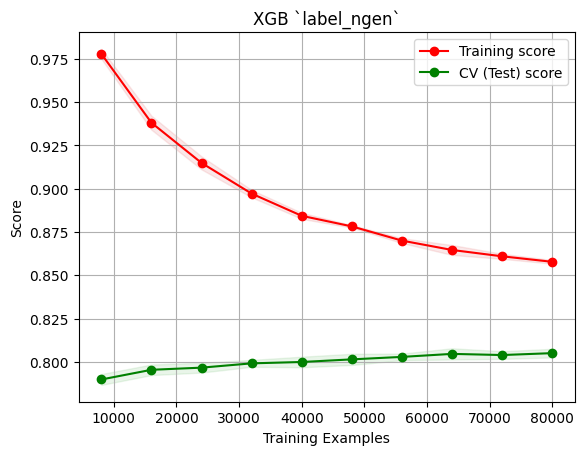

In [8]:
# `label_ngen` balanced dataset. 100_000 sample

params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }

X, y, X_train, y_train, X_test, y_test = h.data_preprocessing(df, n_sample=100_000, label='label_ngen', test_size=0.2, balanced_label=True)

XGB = XGBClassifier(random_state=42, tree_method='approx', n_jobs=4, **params,)

h.plot_learning_curve(XGB, X, y, cv=5, title='XGB `label_ngen`', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=25)

### 5.2.1 Conclusion

This are the best values found from the test above. This are the samples count that will be used in the classification tasks.

- `label`:
  - RF: 
    - Tot samples: 18.000
    - Training samples: 14.400
    - Test samples: 3.600
  - XGB: 
    - Tot samples: 20.000
    - Training samples: 16.000
    - Test samples: 4.000
- `label_ngen`:
  - RF:
    - Tot samples: 19.000
    - Training samples: 15.200
    - Test samples: 3.800
  - XGB:
    - Tot samples: 25.000
    - Training samples: 20.000
    - Test samples: 5.000

## 5.3 Classification tasks

In this section we will train two kind of classifier: a Random Forest classifier and XGBoost classifier. Both models will be described in their respective subsections.  
Although the classification results are already great with a simple version of the models, we want to find the best combination of the most important hyperparameters in order to get the best results. We will use the `GridSearchCV` function from `sklearn`. Provided a grid of values, the function will test each combination of the provided hyperparameters and will return the best combination. This will be used to train and test the model, hereafter `RF_best` and `XGB_best`.  

We wanted to test the performance of two similar model, yet different, to have a broaden choice before performing the features importance analysis. For each classification task we'll choose the model with the highest scores and use its result to analyze the features importance. 

### 5.3.1 Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.  
It builds multiple decision trees (hence the term "forest"), each based on a random subset of the training data and features. The randomness helps in creating diversity among the trees, reducing the risk of overfitting and improving the model's generalization. 
For classification tasks, each tree in the forest "votes" for a class, and the class with the most votes becomes the model's prediction and provides a measure of feature importance, indicating which features are most influential in making predictions. This can be helpful for feature selection and understanding the underlying relationships in the data.  

To complete those tasks we use the custom function `gridsearch_RF` that implement the `sklearn` `GridSearchCV` function.  
This time `model_evaluation` custom function will plot also the features importance histogram. We will use it in the next section. 

`gridsearch_scores` will show the training/test scores belonging to the best combination of the hyperparameters.

#### 5.3.1 a) `label` classification

The best hyperparameter combination is `max_depth=25, min_samples_split=20, n_estimators=100`, where:
- max_depth: The maximum depth of the tree
- min_sample_split:T he minimum number of samples required to split an internal node
- n_estimators: The number of trees in the forest

With this combination the RF model reaches a test accuracy ~93%. If we look at the confusion matrix we can see that $>= 88\%$ of the labels are correctly predicted. We can be satisfied with the model and the hyperparameters chosen through `GridSearchCV`.

| |Value |                       
|-----------|-------------------| 
|n_estimators       | 100            |
|max_depth| 25|
|min_samples_split|20|
|Training score|96.4 %|
|Test score|92.7%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 88%           |
|1| 95%|
|2|95%|

Label count before balancing:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64 

Label count after balancing:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

Label count after sampling:
 0    6015
1    6004
2    5981
Name: label, dtype: int64

X_train shape: (14400, 13)
X_test shape: (3600, 13)
y_train shape: (14400,)
y_test shape: (3600,)

Best parameters: 
 {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 500} 

ID of the best combination: 
 53

Training Score:        0.9881944444444445
Test score (Accuracy): 0.9294444444444444



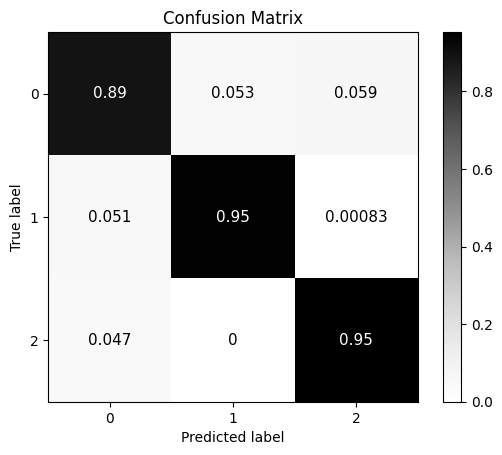

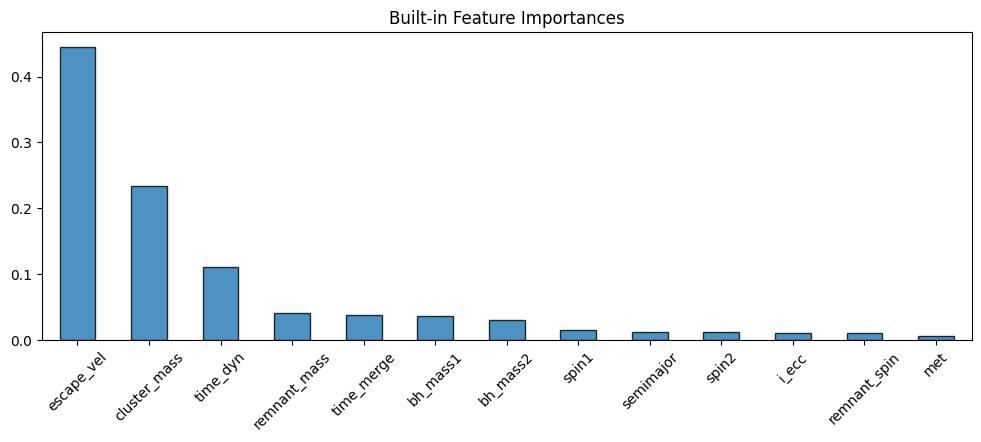

In [6]:
# Define the parameter grid
param_grid_lab_RF = {
    'n_estimators': [50, 100, 300,],
    'max_depth': [5, 15, 25],
    'min_samples_split': [5, 10, 15, 20]
}

X_lab_RF, y_lab_RF, X_train_lab_RF, y_train_lab_RF, X_test_lab_RF, y_test_lab_RF = h.data_preprocessing(
    df, n_sample=18_000, label='label', random_state=42, test_size=0.2, balanced_label=True)

RF_best_lab, y_pred_lab_RF, grid_search_lab_RF = h.gridsearch_RF(param_grid=param_grid_lab_RF, cv=3, 
                                                                 X_train=X_train_lab_RF, y_train=y_train_lab_RF, X_test=X_test_lab_RF, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(RF_best_lab, X_lab_RF, y_lab_RF, X_train_lab_RF, y_train_lab_RF, X_test_lab_RF, y_test_lab_RF, y_pred_lab_RF, bar_plot=True)

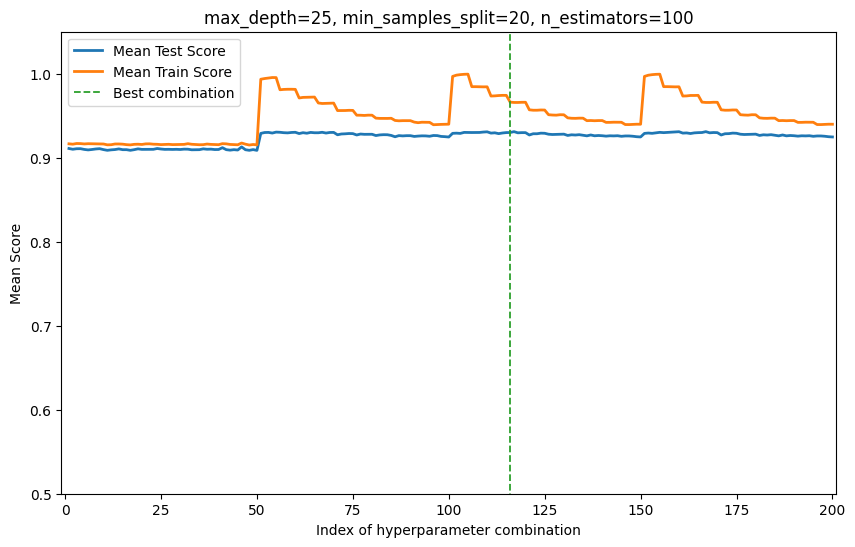

In [21]:
h.gridsearch_scores(grid_search_lab_RF)

#### 5.3.1 b) `label_ngen` classification

The best hyperparameter combination is `max_depth=50, min_samples_split=70, n estimators=300`, where:
- max_depth: The maximum depth of the tree
- min_sample_split:T he minimum number of samples required to split an internal node
- n_estimators: The number of trees in the forest

With this combination the RF model reaches a test accuracy ~80%. If we look at the confusion matrix we can see that the model struggles to classify correctly ~30% of label=1.  
We will try to understand it's a problem related to the model or to the dataset itself.

| |Value |                       
|-----------|-------------------| 
|n_estimators       | 300            |
|max_depth|50|
|min_samples_split|70|
|Training score|86.1 %|
|Test score|80.0%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 87%           |
|1| 73%|

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 1    9506
0    9494
Name: label_ngen, dtype: int64

X_train shape: (15200, 13)
X_test shape: (3800, 13)
y_train shape: (15200,)
y_test shape: (3800,)

Best parameters: 
 {'max_depth': 50, 'min_samples_split': 70, 'n_estimators': 300} 

ID of the best combination: 
 1

Training Score:        0.8620394736842105
Test score (Accuracy): 0.7973684210526316



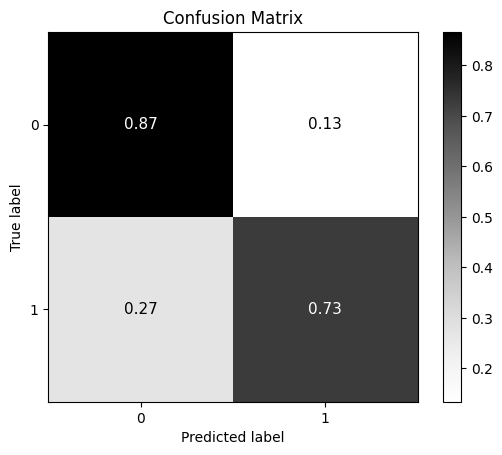

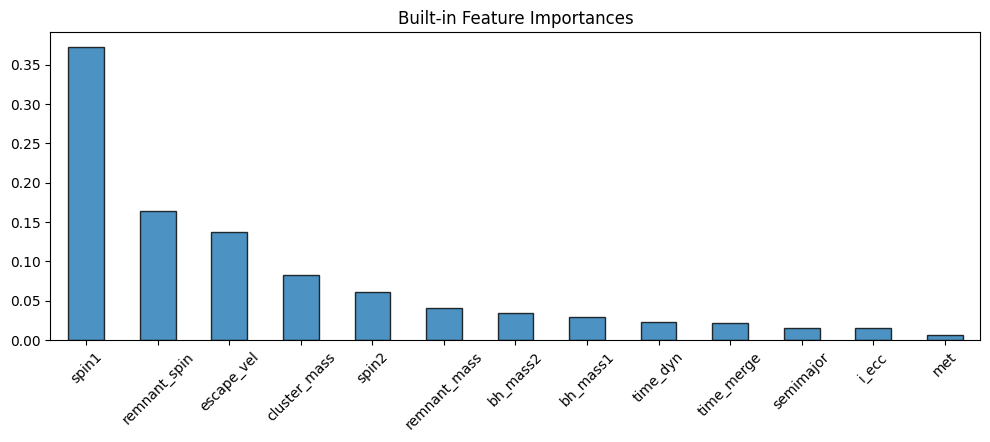

In [3]:
param_grid_ngen_RF = {
    'n_estimators': [200, 300],
    'max_depth': [50, 75, 100],
    'min_samples_split': [70, 80, 90, 100]
}

X_ngen_RF, y_ngen_RF, X_train_ngen_RF, y_train_ngen_RF, X_test_ngen_RF, y_test_ngen_RF = h.data_preprocessing(
    df, n_sample=19_000, label='label_ngen', random_state=42, test_size=0.2, balanced_label=True)

RF_best_ngen, y_pred_ngen_RF, grid_search_ngen_RF = h.gridsearch_RF(param_grid=param_grid_ngen_RF, cv=3, 
                                                                 X_train=X_train_ngen_RF, y_train=y_train_ngen_RF, X_test=X_test_ngen_RF, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(RF_best_ngen, X_ngen_RF, y_ngen_RF, X_train_ngen_RF, 
                   y_train_ngen_RF, X_test_ngen_RF, y_test_ngen_RF, y_pred_ngen_RF, bar_plot=True)

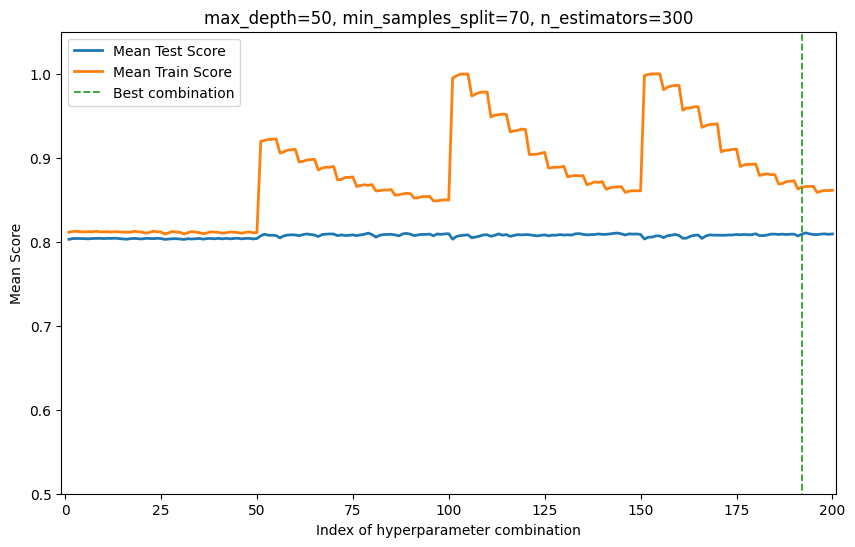

In [9]:
h.gridsearch_scores(grid_search_ngen_RF)

### 5.3.2 XGBoost Classifier

XGBoostClassifier is an implementation of the XGBoost algorithm for classification tasks. XGBoost stands for Extreme Gradient Boosting, which is an advanced implementation of gradient boosting algorithms.  

XGBoostClassifier is based on the gradient boosting framework, which is an ensemble learning technique where multiple weak learners (typically decision trees) are combined to form a strong learner. It builds trees sequentially, where each subsequent tree corrects the errors made by the previous ones, thus gradually improving the overall model performance.  
XGBoost incorporates regularization techniques to prevent overfitting, such as L1 and L2 regularization on the leaf weights and tree complexity.  
Similar to RandomForestClassifier, XGBoostClassifier provides feature importance scores, allowing users to identify the most influential features in the model.

To complete those tasks we use the custom function `gridsearch_XGB` that implement the `sklearn` `GridSearchCV` function.  
This time `model_evaluation` custom function will plot also the features importance histogram. We will use it in the next section. 

`gridsearch_scores` will show the training/test scores belonging to the best combination of the hyperparameters.

#### 5.3.2 a) `label` classification

The best hyperparameter combination is `colsample_bytree=0.5, gamma=O.5, learning_rate=0.1, max_depth=25, n estimators=200, reg_lambda=5, subsample=0.3`, where:
- colsample_bytree: Subsample ratio of columns when constructing each tree
- gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree
- learning_rate: Step size shrinkage used in update to prevent overfitting
- max_depth: The maximum depth of the tree
- n_estimators: The number of trees in the forest
- reg_lambda: L2 regularization term on weights
- subsample: Subsample ratio of the training instances

With this combination the XGB model reaches a test accuracy ~93%. If we look at the confusion matrix we can see that $>= 88\%$ of the labels are correctly predicted. We can be satisfied with the model and the hyperparameters chosen through `GridSearchCV`.
The training score equal 98.2% is an indication of slight overfitting: the model performs exceptionally well on the training data but fails to generalize completely unseen data.

| |Value |                       
|-----------|-------------------| 
|n_estimators       | 200            |
|max_depth|25|
|colsample_bytree|0.5|
|gamma|0.5|
|learning_rate|0.1|
|reg_lambda|5|
|subsample|0.3|
|----------------|-------|
|Training score | 98.2%|
|Test score| 92.8%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 88%           |
|1| 96%|
|2|94%|

Label count before balancing:
 1    2788313
0     433627
2       7207
Name: label, dtype: int64 

Label count after balancing:
 1    7207
0    7207
2    7207
Name: label, dtype: int64

Label count after sampling:
 2    6672
0    6667
1    6661
Name: label, dtype: int64

X_train shape: (16000, 13)
X_test shape: (4000, 13)
y_train shape: (16000,)
y_test shape: (4000,)

Best parameters: 
 {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 200, 'reg_lambda': 5, 'subsample': 0.3} 

ID of the best combination: 
 152

Training Score:        0.9816875
Test score (Accuracy): 0.928



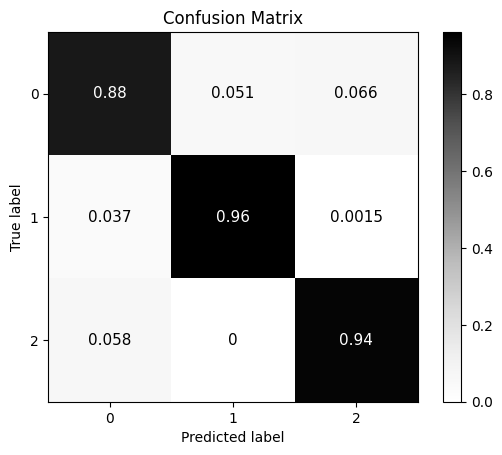

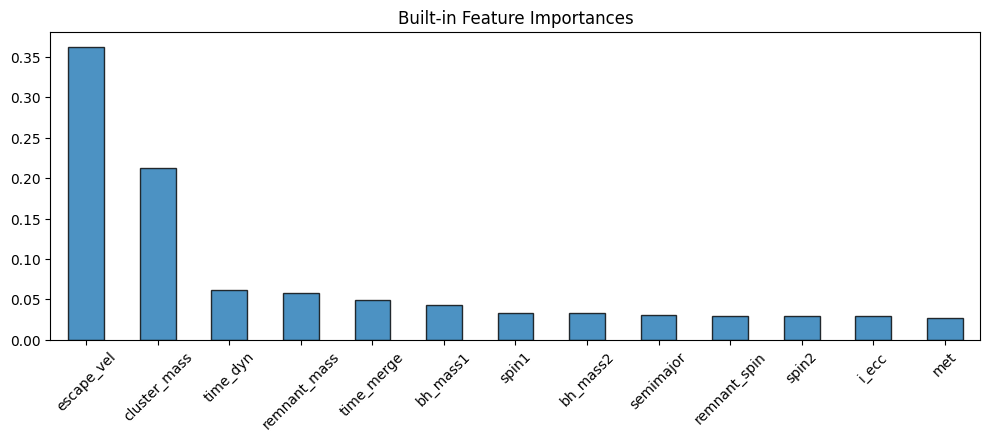

In [6]:
# Define the parameter grid
param_grid_lab_xgb = {
    'n_estimators': [100, 150, 200],    # Number of boosting rounds
    'max_depth': [25, 30],                # Maximum depth of each tree
    'learning_rate': [0.1, 0.2],           # Learning rate (shrinkage parameter)
    'subsample': [0.3, 0.5],                # Fraction of samples used for training each tree
    'colsample_bytree': [0.3, 0.5],         # Fraction of features used for training each tree
    'gamma': [0.2, 0.5],                      # Minimum loss reduction required to make a further partition on a leaf node
    #'reg_alpha': [0, 0.1, 0.2],                  # L1 regularization term on weights
    'reg_lambda': [5, 10],                 # L2 regularization term on weights
}

X_lab_xgb, y_lab_xgb, X_train_lab_xgb, y_train_lab_xgb, X_test_lab_xgb, y_test_lab_xgb = h.data_preprocessing(
    df, n_sample=20_000, label='label', random_state=42, test_size=0.2, balanced_label=True)

XGB_best_lab, y_pred_lab_xgb, grid_search_lab_xgb = h.gridsearch_XGB(param_grid=param_grid_lab_xgb, cv=3, 
                                                                 X_train=X_train_lab_xgb, y_train=y_train_lab_xgb, X_test=X_test_lab_xgb, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(XGB_best_lab, X_lab_xgb, y_lab_xgb, X_train_lab_xgb, 
                   y_train_lab_xgb, X_test_lab_xgb, y_test_lab_xgb, y_pred_lab_xgb, bar_plot=True)

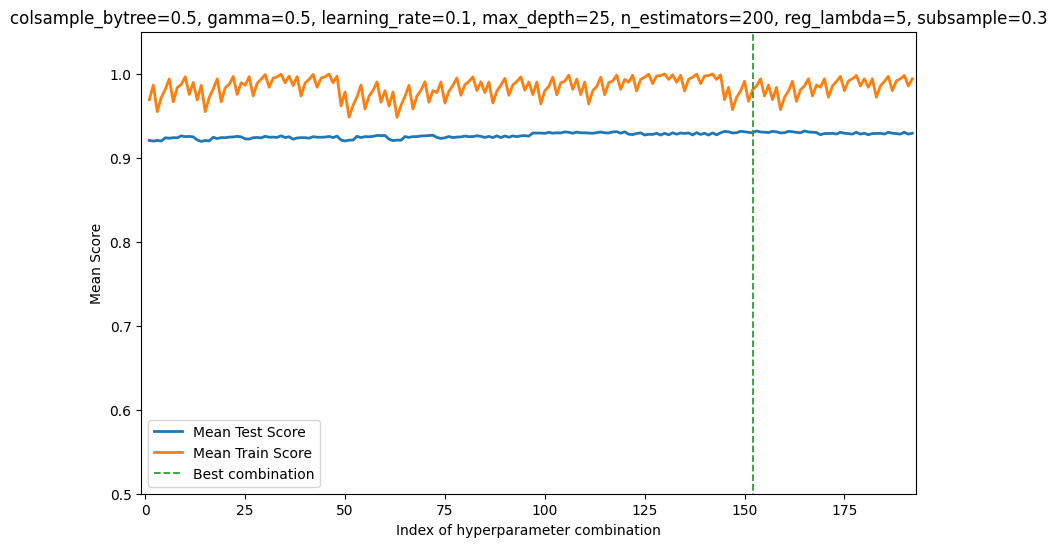

In [8]:
h.gridsearch_scores(grid_search_lab_xgb)

#### 5.3.2 b) `label_ngen` classification

The best hyperparameter combination is `colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=50, n estimators=200, reg_lambda=30, subsample=0.3`, where:
- colsample_bytree: Subsample ratio of columns when constructing each tree
- gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree
- learning_rate: Step size shrinkage used in update to prevent overfitting
- max_depth: The maximum depth of the tree
- n_estimators: The number of trees in the forest
- reg_lambda: L2 regularization term on weights
- subsample: Subsample ratio of the training instances

With this combination the XGB model reaches a test accuracy ~80%. In this case the model seems not to overfit, however it still struggles to classify correctly ~25% of label=1. In addition to the RF model results, this could be an indication of a dataset-related problem. 

| |Value |                       
|-----------|-------------------| 
|n_estimators       | 200            |
|max_depth|50|
|colsample_bytree|0.5|
|gamma|0.5|
|learning_rate|0.1|
|reg_lambda|30|
|subsample|0.3|
|----------------|-------|
|Training score | 86.8%|
|Test score| 80.0%|

-------------------

|**Label** | Correct predictions |                       
|-----------|-------------------| 
|0       | 86%           |
|1| 74%|

Label count before balancing:
 0    2827812
1     401335
Name: label_ngen, dtype: int64 

Label count after balancing:
 0    401335
1    401335
Name: label_ngen, dtype: int64

Label count after sampling:
 0    12568
1    12432
Name: label_ngen, dtype: int64

X_train shape: (20000, 13)
X_test shape: (5000, 13)
y_train shape: (20000,)
y_test shape: (5000,)

Best parameters: 
 {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 200, 'reg_lambda': 30, 'subsample': 0.3} 

ID of the best combination: 
 98

Training Score:        0.8679
Test score (Accuracy): 0.8004



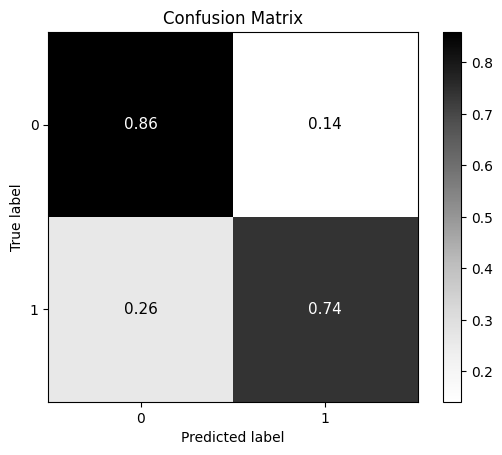

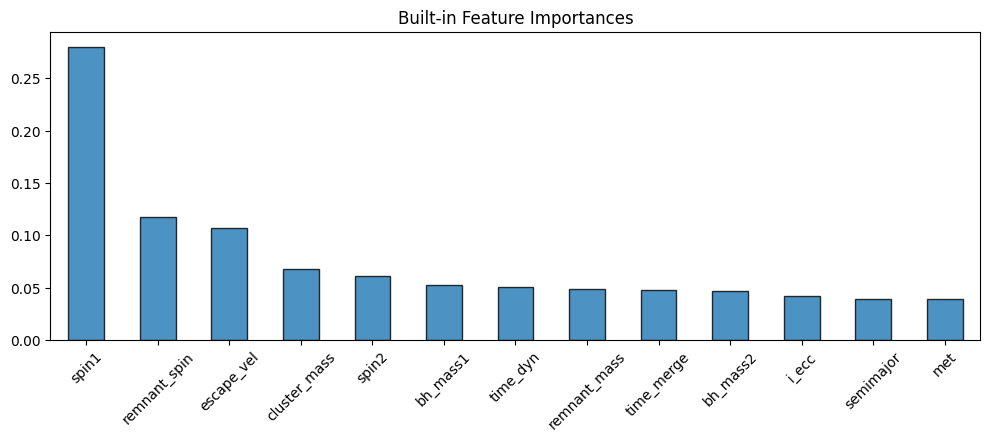

In [15]:
# Define the parameter grid
param_grid_ngen_xgb = {
    'n_estimators': [200, 300],    # Number of boosting rounds
    'max_depth': [50, 75, 100],                # Maximum depth of each tree
    'learning_rate': [0.1, 0.2],           # Learning rate (shrinkage parameter)
    'subsample': [0.3, 0.5],                # Fraction of samples used for training each tree
    'colsample_bytree': [0.3, 0.5],         # Fraction of features used for training each tree
    'gamma': [0.5, 0.8],                      # Minimum loss reduction required to make a further partition on a leaf node
    # 'reg_alpha': [10, 20],                  # L1 regularization term on weights
    'reg_lambda': [20, 30],                 # L2 regularization term on weights
    #'min_child_weight': [1, 3, 5],               # Minimum sum of instance weight needed in a child
}

X_ngen_xgb, y_ngen_xgb, X_train_ngen_xgb, y_train_ngen_xgb, X_test_ngen_xgb, y_test_ngen_xgb = h.data_preprocessing(
    df, n_sample=25_000, label='label_ngen', random_state=42, test_size=0.2, balanced_label=True)

XGB_best_ngen, y_pred_ngen_xgb, grid_search_ngen_xgb = h.gridsearch_XGB(param_grid=param_grid_ngen_xgb, cv=3, 
                                                                 X_train=X_train_ngen_xgb, y_train=y_train_ngen_xgb, X_test=X_test_ngen_xgb, 
                                                                 n_jobs=25, verbose=0)

h.model_evaluation(XGB_best_ngen, X_ngen_xgb, y_ngen_xgb, X_train_ngen_xgb, 
                   y_train_ngen_xgb, X_test_ngen_xgb, y_test_ngen_xgb, y_pred_ngen_xgb, bar_plot=True)

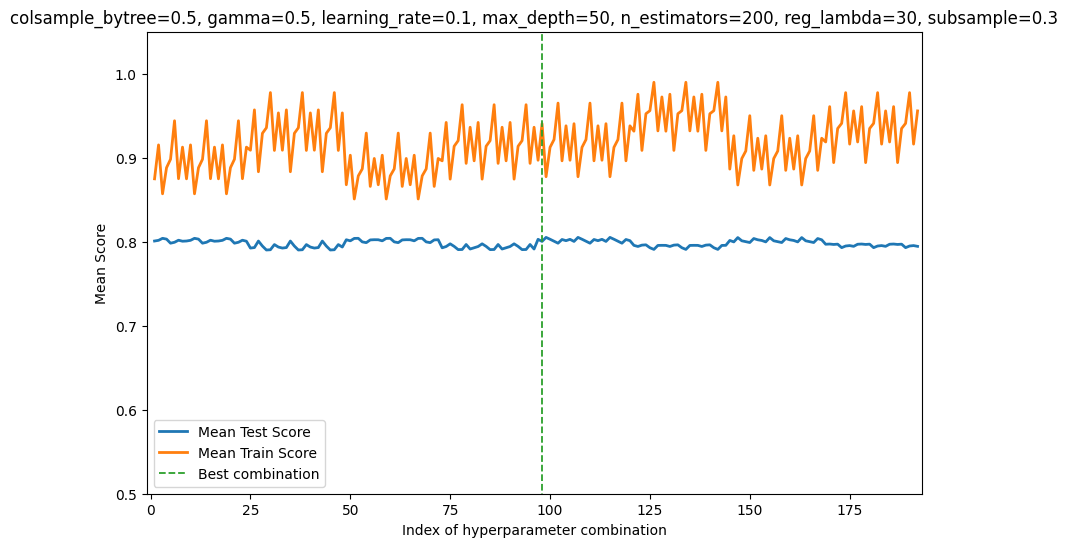

In [16]:
h.gridsearch_scores(grid_search_ngen_xgb)

### 5.3.3 Discussion

- `label`: Both models have optimal training and test accuracy. `XGB_best` might be affected by a slightly overfitting. The labels prediction is similar and optimal.

- `label_ngen`: Two different models struggle to classify approximately 25%/30% of label `1`, despite the dataset being balanced and the models not exhibiting strong overfitting. There could be several reasons for this behavior:
  - **Inherent Complexity of the Data**: the data might contain patterns that are inherently difficult to capture. Certain data distributions or relationships could be challenging for the models to learn;
  -  Even though the classes are balanced overall, there might be specific subgroups within the classes that are imbalanced, and the models might struggle to capture patterns within these subgroups;
  -  It's possible that the models used are too complex or too simple for the given task.
  
Since both models have similar result, we choose to use in the feature analysis the RandomForestClassifier model `RF_best`, because is less complex and easier (i.e. faster) to train.

# 6. Features importance analysis


We split our features importance analysis in two part for the two different tasks:
 - `label`: Feature importance analysis will tell us which features are most important to understand which system belongs to which host stellar cluster
 - `label_ngen`: Feature importance analysis will tell us which features are most important that lead systems to evolve and which do not

To do so we will visually inspect the results from the SHAP analysis (explained in the next sub-section). `shap_explainer` takes in input the trained model and the background data that we want to integrate (i.e. analyze to understand features importance w.r.t. those data). The parameter `n_sample` is optional. It refers to the number of samples to select. Since the model is already trained, anywhere from 100 to 1000 random background samples are good sizes to use.  
Once the SHAP values are calculated we can plot those values in 2 different kind of plot, using two custom functions: `plot_shap_bar` and
`plot_shap_violin`. The meaning of the plots is explained in the next sub-section-

## 6.1 SHAP values

[SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values are a method used to explain the predictions of machine learning models. They were introduced by [Lundberg and Lee](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) in 2017 and are based on cooperative game theory.

SHAP values provide a way to allocate the contribution of each feature in a prediction model to the final prediction. They aim to quantify the impact of each feature on the prediction outcome by considering all possible combinations of features and calculating the contribution of each feature in each combination.

The core idea behind SHAP values is the concept of [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), which is a method for fairly distributing the payout of a cooperative game among the players based on their individual contributions. In the context of machine learning models, the features are treated as players, and the prediction outcome is the payout.

To calculate SHAP values, a baseline reference is established, which serves as a starting point for the feature contributions. Then, different combinations of features are created, and for each combination, the model predictions are observed. The contribution of each feature is determined by comparing the predictions with and without the feature included.

SHAP values provide several advantages in interpreting machine learning models. They offer a unified framework for feature importance measurement that is both consistent and locally accurate. They also satisfy desirable properties such as consistency, meaning that if a feature is removed or added, the SHAP values change accordingly. Furthermore, SHAP values can be used to explain individual predictions as well as provide an overview of feature importance across the entire dataset.

In our study, we employed three types of visualizations to gain insights into the importance of each feature*.

**Summary plot (bar type) for global inspection**  
This kind of plot examine the mean absolute SHAP value for each feature across all of the data. This quantifies, on average, the magnitude of each feature's contribution towards the predicted label. If a feature has a high mean SHAP value, it suggests that it generally has a strong influence on the predictions. Conversely, a low mean SHAP value indicates that the feature has less impact on the model's predictions. Mean absolute SHAP values are essentially a drop-in replacement for more traditional feature importance measures but have two key advantages:

- Mean absolute SHAP values are more theoretically rigorous, and relate to which features impact predictions most. Conventional feature importances are measured in more abstract and algorithm-specific ways, and are determined by how much each feature improves the model's predictive performance.
- Mean absolute SHAP values have intuitive units, like the target variable. Feature importances are often expressed in counterintuitive units based on complex concepts such as tree algorithm node impurities.
The features are presented in descending order of importance, with the most significant feature listed at the top and the less significant features listed towards the bottom.

**Summary plot (bar type) for labels inspection**  
We created separate plots for each label to gain a more accurate understanding of the feature importance. By examining the importance of features for each label individually, we obtained specific insights into their contributions to the prediction accuracy for each class.

**Summary plot (violin type) for each label (evolution channel)**  
This is the most useful type of plot for our study. A SHAP violin plot provides a visual representation of the distribution of SHAP values for different features in the model. It helps in understanding the impact of each feature on the model's predictions.

- Vertical Axis: The vertical axis represents the features in the model. The features are presented in descending order of importance.

- Horizontal Axis: The horizontal axis represents the range of SHAP values. It spans from negative to positive values, indicating the direction and magnitude of the feature's influence on the predictions.

- Violin Shape: Each violin-shaped distribution represents the density of the SHAP values for a specific feature. The width of the violin at a given point represents the density or frequency of SHAP values at that point.

  - A wider section of the violin indicates a higher density of SHAP values, indicating a stronger influence of the feature on the predictions.
  - A narrower section of the violin indicates a lower density of SHAP values, suggesting a weaker influence.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

The SHAP violin plot allows you to compare the distributions of SHAP values across different features. It helps identify features that have consistent and impactful contributions (wider violins with higher densities) and those that have less influence (narrower violins with lower densities).

The plot can also reveal features with bimodal or asymmetric distributions, indicating the presence of different subgroups or distinct patterns in the data that affect the predictions differently.

* ref1: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* ref2: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

## 6.2 `label` features importance
*description*

In [8]:
lab_shap_values = h.shap_explainer(RF_best_lab, X_test_lab_RF, n_sample=None) # calculate shap values. We want to explain test data

### 6.2.1 Summary plot (bar type)

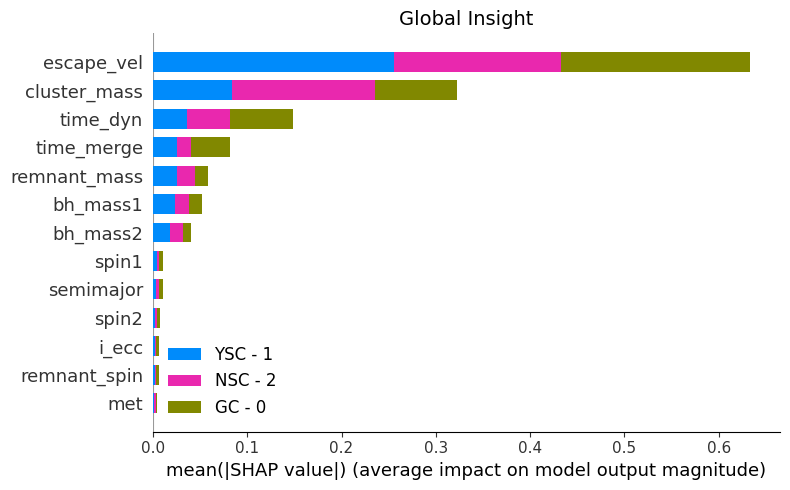

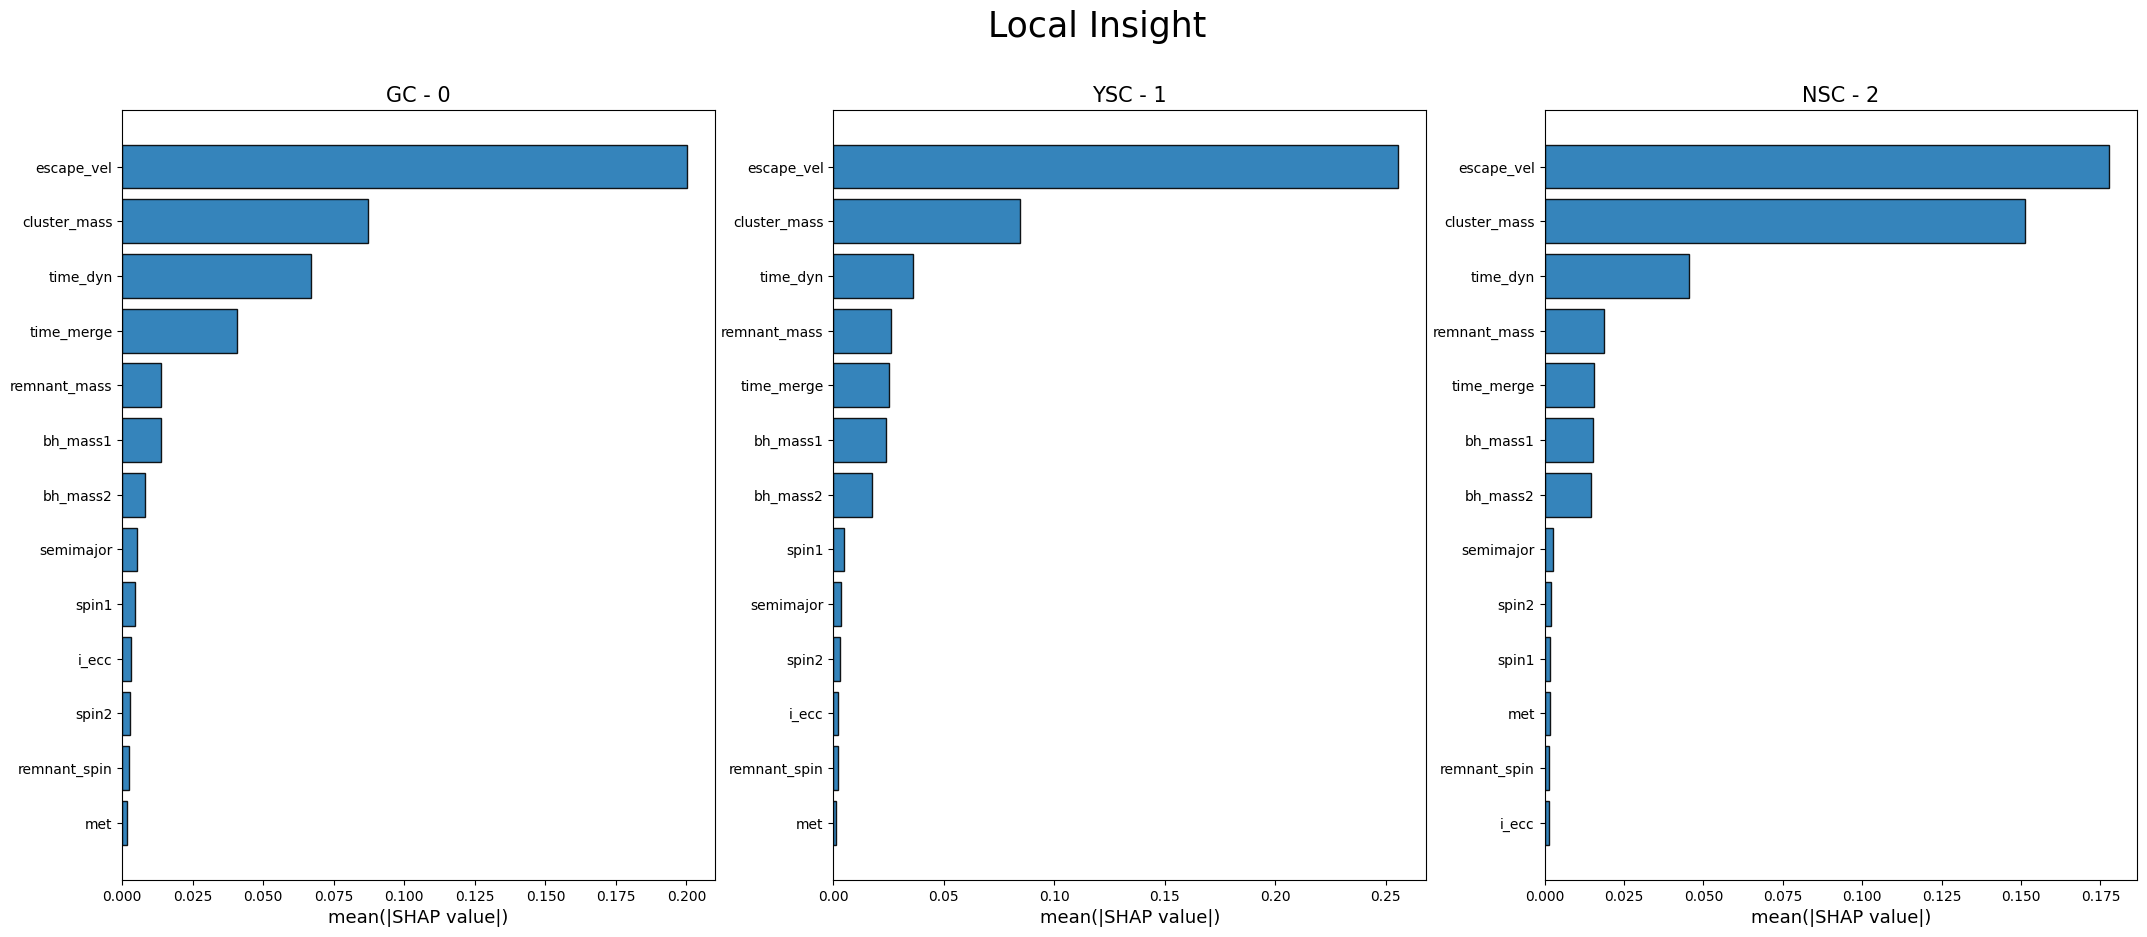

In [9]:
h.plot_shap_bar(lab_shap_values, X_lab_RF)

### 6.2.2 Summary plot (violin type) for each label

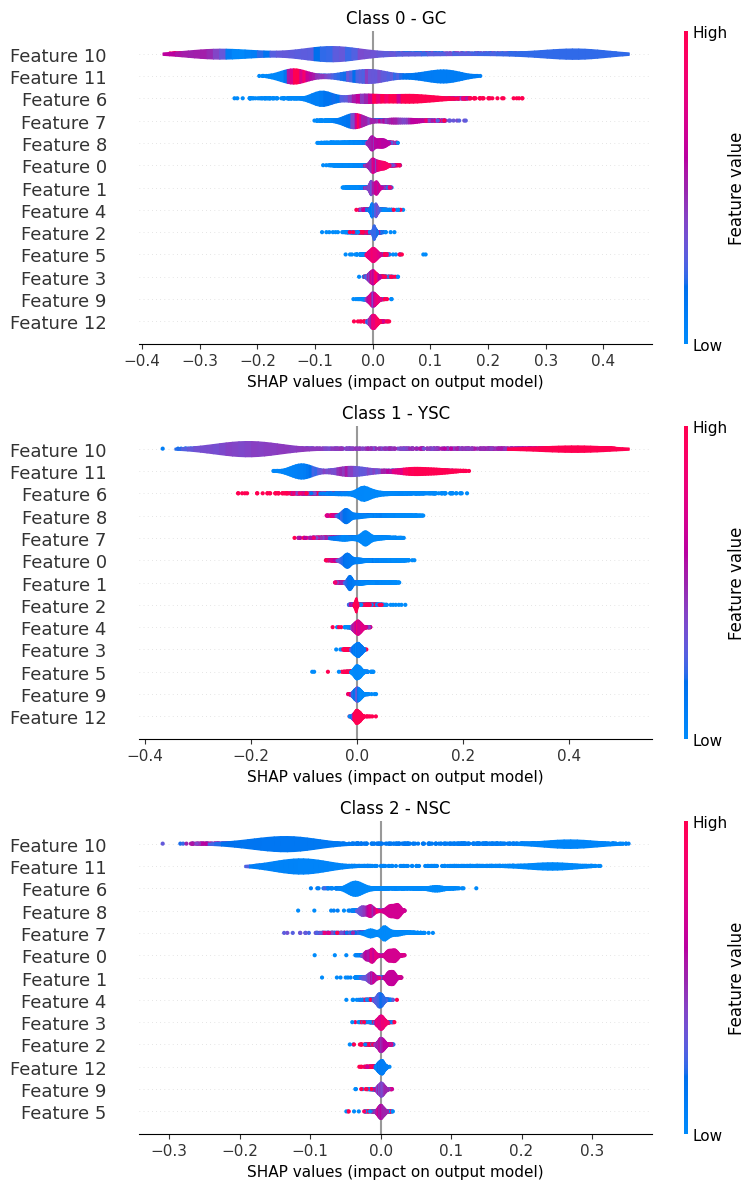

In [12]:
h.plot_shap_violin(shap_values=lab_shap_values, data=X_test_lab_RF, X=X_lab_RF, n_sample=None)

## 6.3 `label_ngen` features importance
*description*

In [4]:
ngen_shap_values = h.shap_explainer(RF_best_ngen, X_test_ngen_RF, n_sample=1_000)

### 6.3.1 Summary plot (bar type)

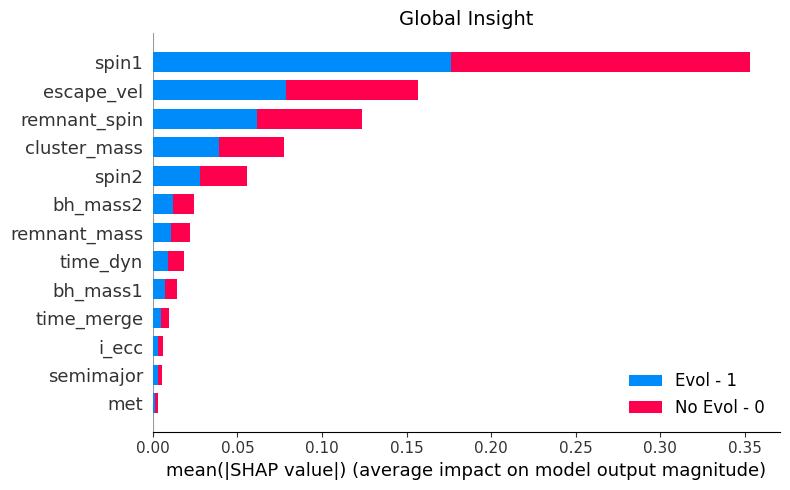

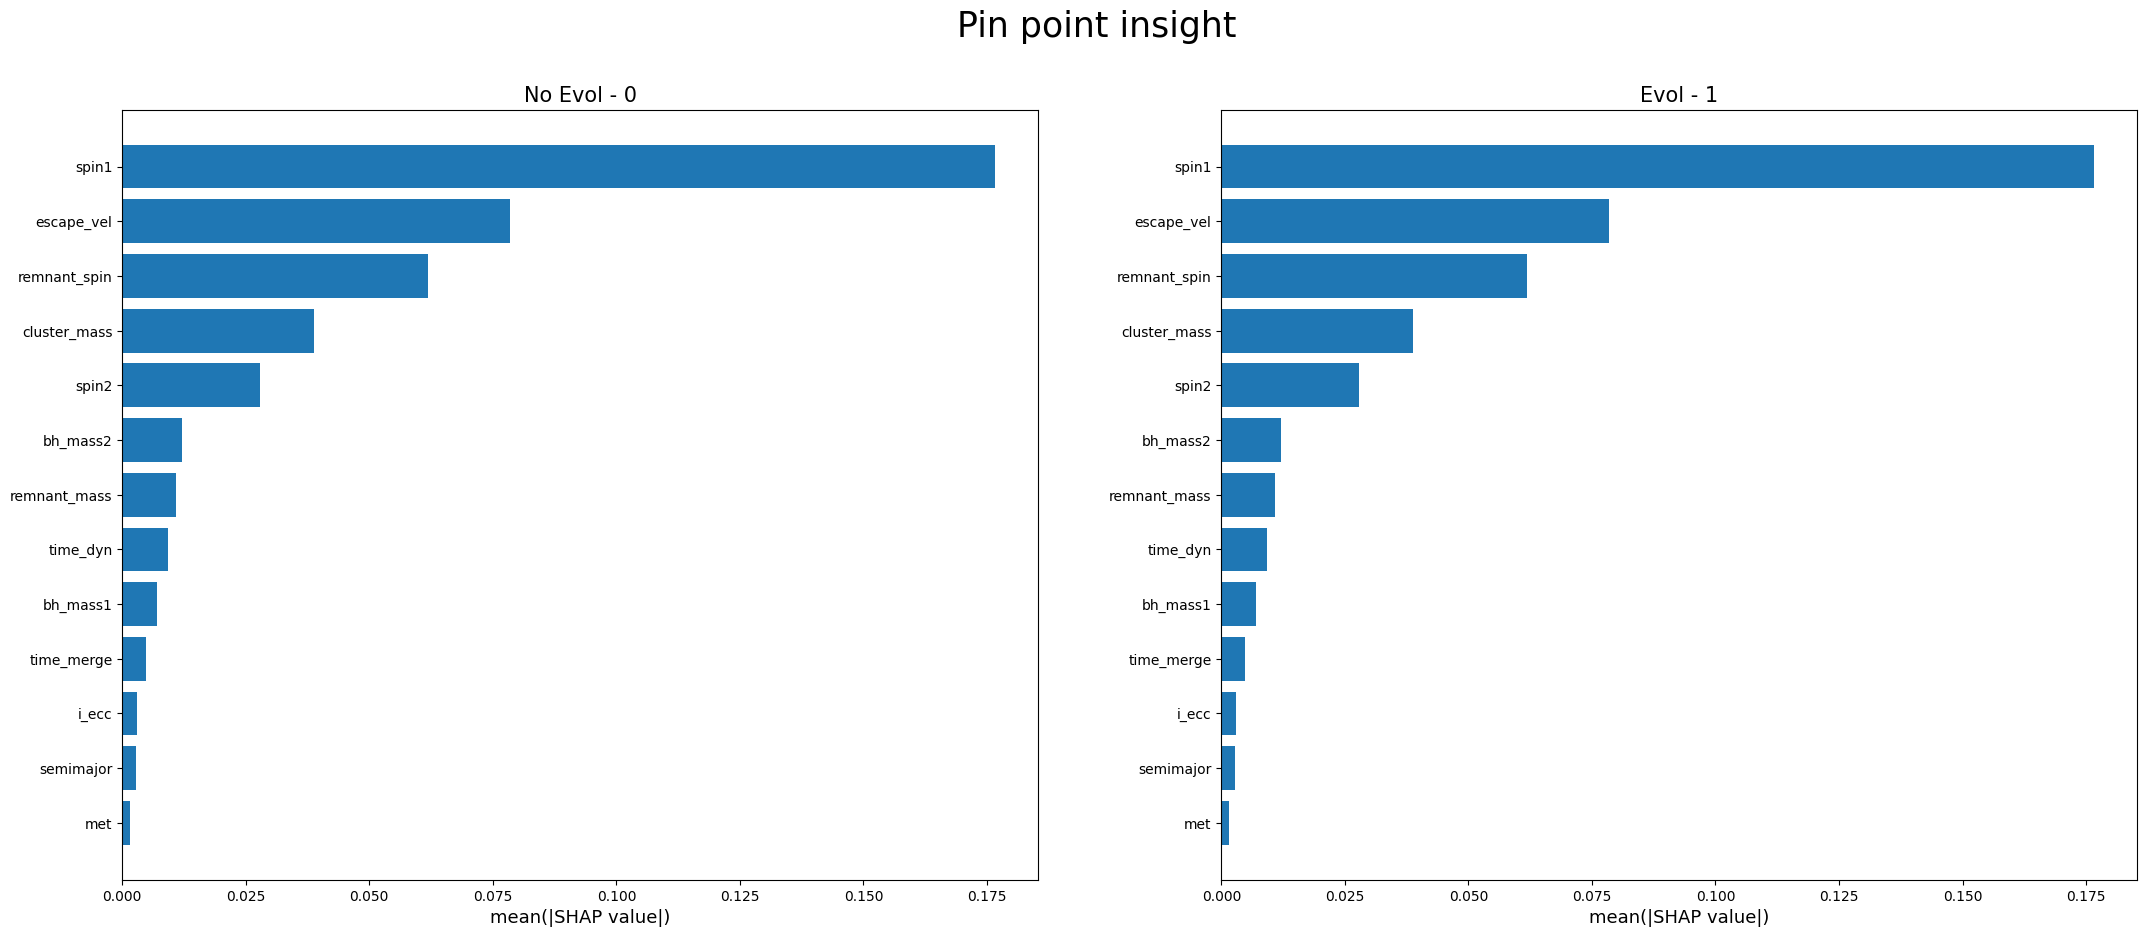

In [9]:
h.plot_shap_bar(shap_values=ngen_shap_values, X=X_ngen_RF)

### 6.3.2 Summary plot (violin type) for each label

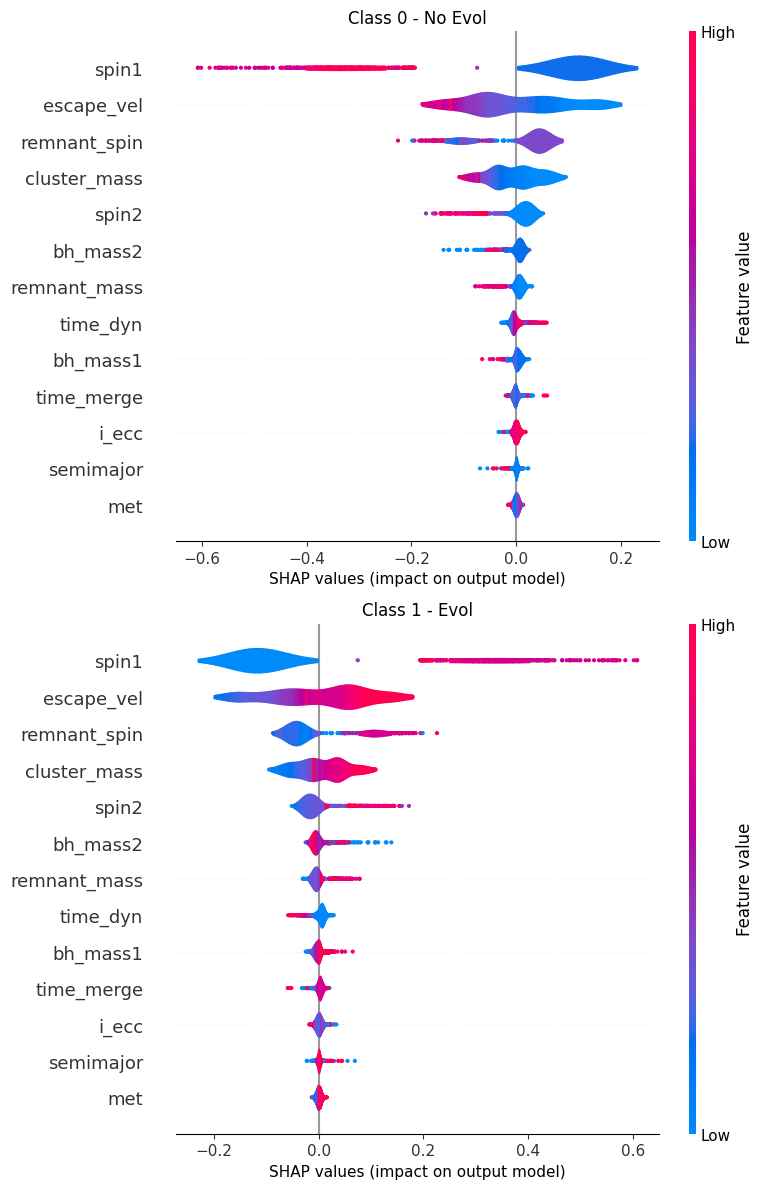

In [6]:
h.plot_shap_violin(shap_values=ngen_shap_values, data=X_test_ngen_RF, X=X_ngen_RF, n_sample=1_000)